# The problem

We want to be able to take a "JS component" and use it from python, in a jupyter notebook.

By "JS component" I mean "some JS+HTML+CSS that defines an element, view, or full 'app' whose functionality can be reused in various places". 

The idea is to be able to facilitate reuse between front-end dev and back-end dev
(in particular, analysts and ML engineers). 
We'd like, for instance, an analyst working within a notebook to import a python interface 
to some rich data-explorer component written in ReactJS, feed it what it needs (e.g. a data source/target), 
and then use the component's features fully, enabling the work done in it to then be 
used back in the notebook. 

For example, saw we take a [forced-directed graph](https://towardsdatascience.com/large-graph-visualization-tools-and-approaches-2b8758a1cd59) or [tsne viz](https://github.com/karpathy/tsnejs) tool that visualizes data, enabling us to view, filter and select data points. 
We'd like our analysts to be able to provide their data, or point to a source where the data can be found, 
and then once they find an select the data they want to work with, using the features of the tool,
be able to extract that data and get it into some python collection that they can then continue their analysis with. 

Here's a proof-of-concept solution for the example described above, along with other instances of this class.

Use some persisted data store and a platform-independent format as the middleware for py and js communication.
* From python, we write the data to a DB or files in a JS-friendly format (like json or csv).
* JS can then read this data from that source and do it's work
* When we want to communicate some data back to python, we do so again, through the "shared" data store

We could already get far by automating the strategy above as much as possible:
Not obliging the user to set up the data store themselves or have to define the codecs 
necessary to communicate to the data middleware (at least not for the most common data types an analyst might use). 
Perhaps this approach could be further extended to allow some in-memory data store to be used, 
which would improve communication speed. 

We'd like to be able to do this with any JS component, but only through a specific normalized interface. 
That is, the automation of the PY-JS communication setup will be done only for very specific (but open-closed)
python and JS interfaces. To use a third-party JS component, we will need to wrap it into a facade that 
is compliant with our normalized interface that we will rely on, and the python interface will be totally determined by this.
This facade needs to be open-closed though. 
That is, it needs to be able to accomodate any "lines of communication" between python and the JS component. 

Note: Some solutions work in some environments, and not in others. 
Typically, I've seen some things work in my browser-based notebook, but not in VScode notebook. 
We don't want to target covering all environments, but at least browser-based and VScode, which should cover a lot of users. 



## Two-way JS-PY communication

Integrating JavaScript components with a Python notebook and enabling two-way communication can be a bit complex, but it's definitely possible. Here's a high-level overview of how you can achieve this:
1.	**Embedding JavaScript in Jupyter Notebook**: You can use the `IPython` core display module to embed JavaScript code in a cell.
2.	**Creating a JavaScript Component**: Define your JavaScript component and its functionality. This can be a simple button or a more complex interactive component.
3.	**Communication from Python to JavaScript**: You can call a JavaScript function from Python using the `IPython` display module.
4.	**Communication from JavaScript to Python**: This is the tricky part. Jupyter provides a `Jupyter.notebook.kernel.execute` method that allows JavaScript to run Python code.


# Solutions

## Just IPython

Works on browser, not in VScode.

[See discussion](https://github.com/i2mint/jy/discussions/3#discussioncomment-6862019)

In [13]:
from IPython.display import display, HTML, Javascript

js_code = """
function sendToPython(){
    var data = document.querySelector("#myInput").value;
    var kernel = IPython.notebook.kernel;
    kernel.execute("data_from_js = '" + data + "'");
}

document.querySelector("#myButton").addEventListener("click", function(){
    sendToPython();
});
"""

HTML_code = """
<input type="text" id="myInput" placeholder="Enter some text">
<button id="myButton">Submit</button>
<script type="text/Javascript">{}</script>
""".format(js_code)

data_from_js = None   # not even necessary to initialize, but makes checking no throw an error, but print None instead

In [14]:
# Running this cell should display a text box and a button. Enter some text in the text box and click the button. 
# The text should be sent to Python and stored in the variable data_from_js. 
# The next cell will print the value of data_from_js...
# ... if it works (works on browser but not VSCode, for me)
display(HTML(HTML_code))

In [15]:
print(data_from_js)

dasdf


In [10]:
from IPython.display import display, HTML, Javascript

js_code = """
function sendToPython(){
    var data = document.querySelector("#myInput").value;
    var kernel = IPython.notebook.kernel;
    kernel.execute("data_from_js = '" + data + "'");
}

document.querySelector("#myButton").addEventListener("click", function(){
    sendToPython();
});
"""

HTML_code = """
<input type="text" id="myInput" placeholder="Enter some text">
<button id="myButton">Submit</button>
<script type="text/Javascript">{}</script>
""".format(js_code)

display(HTML(HTML_code))

## ipywidgets

This solution works both in browser and VSCode!

Unfortunately, it's not what we want. Here, we're making the JS+HTML via ipywidgets. 
What we want is to make any JS component integrated in a notebook. 
Perhaps we can do so **via** `ipywidgets`, using [custom widgets](https://ipywidgets.readthedocs.io/en/7.x/examples/Widget%20Custom.html)

[See discussion](https://github.com/i2mint/jy/discussions/3#discussioncomment-6862673)

In [1]:
import ipywidgets as widgets
from IPython.display import display

# Python function to be called when the button is clicked
def on_button_click(button):
    global data_from_js
    data_from_js = text_input.value
    print(f"Received data: {data_from_js}")

# Create a text input widget
text_input = widgets.Text(
    value='',
    placeholder='Enter some text',
    description='Text:',
    disabled=False
)

# Create a button widget
button = widgets.Button(description="Submit")
button.on_click(on_button_click)

# Display the widgets
display(text_input, button)

Text(value='', description='Text:', placeholder='Enter some text')

Button(description='Submit', style=ButtonStyle())

Received data: hello


In [2]:
print(data_from_js)

hello


# ipywidget injection

To create a custom IPyWidget with HTML and JS code, you can define a Python function that utilizes the `widgets.HTML` class from the `ipywidgets` library to embed the HTML and JS code into the Jupyter Notebook. Here’s a simple Python function that takes HTML and JS code as strings and returns an IPyWidget:

In [6]:
from ipywidgets import HTML

def create_custom_widget(html_code: str, js_code: str):
    # Embed the JS code within script tags and concatenate it with the HTML code
    full_code = html_code + '<script type="text/javascript">' + js_code + '</script>'
    
    # Create and return an HTML widget with the combined code
    return HTML(value=full_code)


You can use this function by passing your HTML and JS code as strings to it and then displaying the returned widget in your Jupyter Notebook. Here’s an example of how to use it:


In [7]:
html_code = '<button id="myButton">Click Me!</button>'
js_code = '''
document.getElementById("myButton").addEventListener("click", function() {
    alert("Button Clicked!");
});
'''

widget = create_custom_widget(html_code, js_code)

# To display the widget in a Jupyter Notebook cell, simply write the widget variable name in a cell and run it.
widget


HTML(value='<button id="myButton">Click Me!</button><script type="text/javascript">\ndocument.getElementById("…

This example will create a button, and when you click it, an alert box will appear with the message "Button Clicked!".

## Results

I tried it in VSCode and I'm not getting the alert. 
Troubleshoot.

For example consider this:

Where might that alert message actually be going? I'm not getting an error message. I'm just getting nothing. In a browser I'd be able to inspect what's happening, but in VSCOde I don't know what to do.

Might there be a special setting in VsCode that lets me override a "safety" default that is blocking the alert pop up?

Could I try a different even listener callback? One that, for example, sends a value python?

In a VSCode notebook, the behavior of JavaScript can be different from that in a traditional Jupyter notebook running in a browser. Here are some steps to troubleshoot the issue:

1. **Alert Restrictions**: VSCode might restrict or sandbox the execution of certain JavaScript functions, such as `alert()`, for security reasons. Instead of using `alert()`, you can try logging the message to the console using `console.log()`. This will allow you to see if the JavaScript code is being executed at all.

2. **Check the Developer Console**: VSCode has a developer console where you can see any errors or logs. To access it:
   - Go to the menu: `Help` > `Toggle Developer Tools`.
   - Check the `Console` tab for any errors or logs.

3. **Send Data to Python**: Instead of using an alert to display a message, you can send data back to Python from JavaScript. Here's an example of how you can modify the JavaScript code to send data to Python:

   ```javascript
   function sendToPython(){
       var data = document.querySelector("#myInput").value;
       var kernel = IPython.notebook.kernel;
       kernel.execute("data_from_js = '" + data + "'");
       kernel.execute("print('Received data from JS: ' + data_from_js)");
   }
   ```

   This will print the received data in the notebook cell output.

4. **VSCode Settings**: There might be settings or extensions in VSCode that interfere with the execution of JavaScript in notebooks. Ensure that you have the latest version of the Jupyter extension for VSCode installed. Also, check if there are any settings related to content security or script execution that might be blocking the JavaScript.

5. **Alternative Approach**: If you're trying to create an interactive widget, consider using `ipywidgets` or other Python-based interactive tools that are designed to work seamlessly with Jupyter notebooks, including in VSCode.

6. **External Libraries**: Ensure that any external libraries or dependencies required by your JavaScript code are correctly loaded and accessible in the VSCode notebook environment.

7. **Test in a Browser**: As a sanity check, run the same code in a traditional Jupyter notebook in a browser to see if the issue is specific to VSCode or if it's something in the code itself.

If you've tried the above steps and are still facing issues, please provide more details about the exact code and setup, and I'll do my best to assist further.

## Embedding Javascript

In [75]:
# alert NOT showing in VSCode notebook (but does show in browser)
# Print shows in neither (CORS problem)
from IPython.display import display, HTML, Javascript

def hello_from_python():
    print("Hello from Python!")

# Define and call the JavaScript function
js_code = """
function sayHello() {
    alert('Hello from JavaScript!');
    // Call a Python function from JavaScript
    Jupyter.notebook.kernel.execute('hello_from_python()');
}
sayHello();  // Call the function
"""

# Embed the JavaScript code in the notebook
display(Javascript(js_code))

<IPython.core.display.Javascript object>

In [76]:
# Tried replacing 
#    Jupyter.notebook.kernel.execute
# with
#    IPython.notebook.kernel.execute
# BUT, same thing:
# - alert NOT showing in VSCode notebook (but does show in browser)
# - print shows in neither (CORS problem)
from IPython.display import display, HTML, Javascript

js_code = """
function sayHello() {
    alert('Hello from JavaScript!');
    // Call a Python function from JavaScript
    IPython.notebook.kernel.execute('hello_from_python()');
}
sayHello();
"""

display(Javascript(js_code))

<IPython.core.display.Javascript object>

In [4]:
# Button showing, but alert not showing in VSCode notebook!

from IPython.display import display, HTML

# Define a simple JavaScript function within an HTML script tag
js_code = """
<script>
function sayHello() {
    alert('Hello from JavaScript!');
    // Call a Python function from JavaScript
    Jupyter.notebook.kernel.execute('hello_from_python()');
}
</script>
<button onclick="sayHello()">Click Me!</button>
"""

# Embed the JavaScript code in the notebook using HTML
display(HTML(js_code))


In [73]:
import ipywidgets as widgets
from IPython.display import display

def on_button_click(button):
    print("Button clicked!")

button = widgets.Button(description="Click Me!")
button.on_click(on_button_click)
display(button)

Button(description='Click Me!', style=ButtonStyle())

Button clicked!
Button clicked!


In [9]:
from IPython.display import display, HTML, Javascript

js_code = """
function sendToPython(data){
    var kernel = IPython.notebook.kernel;
    kernel.execute("data_from_js = '" + data + "'");
}

document.querySelector("#myButton").addEventListener("click", function(){
    sendToPython(this.innerHTML);
});
"""

HTML("""
<button id="myButton">Click me!</button>
<script type="text/Javascript">{}</script>
""".format(js_code))

In [8]:
def python_callback(data):
    print(f"Received data from JS: {data}")

# This will be called automatically when the button is clicked
data_from_js = None

if data_from_js:
    python_callback(data_from_js)

In [13]:
import ipywidgets as widgets
from IPython.display import display

def on_button_click(b):
    print(b)
    print(f"{dir(b)}")
    d[key] = text.value

def my_function(d, key):
    text = widgets.Text(description='What you want to tell python:')
    button = widgets.Button(description='Submit')
    button.on_click(on_button_click)

    display(text)
    display(button)

d = dict()

my_function(d, 'key')

Text(value='', description='What you want to tell python:')

Button(description='Submit', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())
['__annotations__', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_active_widgets', '_add_notifiers', '_call_widget_constructed', '_click_handlers', '_comm_changed', '_compare', '_control_comm', '_cross_validation_lock', '_default_keys', '_dom_classes', '_gen_repr_from_keys', '_get_embed_state', '_get_trait_default_generator', '_handle_button_msg', '_handle_control_comm_msg', '_handle_custom_msg', '_handle_msg', '_holding_sync', '_is_numpy', '_lock_property', '_log_default', '_model_id', '_model_module', '_model_module_version', '_model_name', '_msg_callbacks', '_notify_observers', '_notify_trait', '_

NameError: name 'key' is not defined

In [42]:
from IPython.display import display, HTML, Javascript

js_code = """
function sendToPython(){
    var data = document.querySelector("#myInput").value;
    var kernel = IPython.notebook.kernel;
    kernel.execute("data_from_js = '" + data + "'");
}

document.querySelector("#myButton").addEventListener("click", function(){
    sendToPython();
});
"""

HTML_code = """
<input type="text" id="myInput" placeholder="Enter some text">
<button id="myButton">Submit</button>
<script type="text/Javascript">{}</script>
""".format(js_code)

display(HTML(HTML_code))


In [44]:
print(data_from_js)

None


In [14]:
from IPython.display import HTML

def my_function(html, d, key):
    display(HTML(html))

    js_code = """
    const input = document.querySelector('input');
    const button = document.querySelector('button');

    button.addEventListener('click', () => {
        const value = input.value;
        const kernel = IPython.notebook.kernel;
        kernel.execute(`d['${key}'] = '${value}'`);
    });
    """

    display(HTML(f'<script>{js_code}</script>'))

html = """
<div>
  <label for="input">What you want to tell python:</label>
  <input type="text" id="input" name="input">
  <button id="submit">Submit</button>
</div>
"""

d = {}
key = 'my_key'

my_function(html, d, key)

html


None


In [37]:
from IPython.display import HTML

def my_function(html, d, key):
    display(HTML(html))

    js_code = """
    const input = document.querySelector('input');
    const button = document.querySelector('button');

    button.addEventListener('click', () => {
        const value = input.value;
        const kernel = IPython.notebook.kernel;
        kernel.execute(`d['${key}'] = '${value}'`);
    });
    """

    display(HTML(f'<script>{js_code}</script>'))

html = """
<div>
  <label for="input">What you want to tell python:</label>
  <input type="text" id="input" name="input">
  <button id="submit">Submit</button>
</div>
"""

d = {}

from dol import TextFiles

d = TextFiles('/Users/thorwhalen/Dropbox/py/proj/i/jy/misc/data')
key = 'my_key'

my_function(html, d, key)


In [35]:
d[key] = 'foob'

In [36]:
list(d)

['my_key']

In [31]:
pwd

'/Users/thorwhalen/Dropbox/py/proj/i/jy/misc'

In [45]:
from IPython.display import display, Javascript
import ipywidgets as widgets
from IPython.display import display
from traitlets import Unicode

class DataReceiver(widgets.DOMWidget):
    _view_name = Unicode('DataReceiverView').tag(sync=True)
    _view_module = Unicode('dataReceiver').tag(sync=True)
    _view_module_version = Unicode('0.1.0').tag(sync=True)
    value = Unicode().tag(sync=True)

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.value = ""
        self.observe(self.on_value_change, 'value')

    def on_value_change(self, change):
        print(f"Received data from JS: {change['new']}")


In [46]:
%%javascript

require.undef('dataReceiver');

define('dataReceiver', ["@jupyter-widgets/base"], function(widgets) {
    var DataReceiverView = widgets.DOMWidgetView.extend({
        render: function() {
            this.value_changed();
            this.model.on('change:value', this.value_changed, this);
        },

        events: {
            'click #myButton': 'handle_click'
        },

        handle_click: function() {
            var data = document.querySelector("#myInput").value;
            this.model.set('value', data);
            this.touch();
        },

        value_changed: function() {
            var old_value = this.model.previous('value');
            var new_value = this.model.get('value');
        },
    });

    return {
        DataReceiverView: DataReceiverView
    };
});


<IPython.core.display.Javascript object>

In [47]:
receiver = DataReceiver()

HTML_code = """
<input type="text" id="myInput" placeholder="Enter some text">
<button id="myButton">Submit</button>
"""

display(HTML(HTML_code))
display(receiver)

DataReceiver()

In [48]:
from IPython.display import display, HTML, Javascript

js_code = """
function sendToPython(){
    var data = document.querySelector("#myInput").value;
    var kernel = IPython.notebook.kernel;
    kernel.execute("data_from_js = '" + data + "'");
    kernel.execute("print('Received data from JS: ' + data_from_js)");
}

document.querySelector("#myButton").addEventListener("click", function(){
    sendToPython();
});
"""

HTML_code = """
<input type="text" id="myInput" placeholder="Enter some text">
<button id="myButton">Submit</button>
<script type="text/Javascript">{}</script>
""".format(js_code)

display(HTML(HTML_code))


In [49]:
js_code = """
function getInputValueAndSendToPython(){
    var data = document.querySelector("#myInput").value;
    return data;
}
"""

display(Javascript(js_code))


<IPython.core.display.Javascript object>

In [52]:
def handle_input_value(value):
    print(f"Received data from JS: {value}")

HTML_code = """
<input type="text" id="myInput" placeholder="Enter some text">
<button onclick="IPython.notebook.kernel.execute('handle_input_value("' + getInputValueAndSendToPython() + '")')">Submit</button>
"""

display(HTML(HTML_code))

In [53]:
import ipywidgets as widgets

# Create a text input widget
text_input = widgets.Text(
    value='',
    placeholder='Enter some text',
    description='Input:',
    disabled=False
)

# Create a button widget
submit_button = widgets.Button(description="Submit")

# Define the button click callback
def on_button_click(button):
    print(f"Received data: {text_input.value}")

submit_button.on_click(on_button_click)

# Display the widgets
display(text_input, submit_button)

Text(value='', description='Input:', placeholder='Enter some text')

Button(description='Submit', style=ButtonStyle())

Received data: asdf


In [54]:
import ipywidgets as widgets
from traitlets import Unicode, validate

class CustomTextInput(widgets.DOMWidget):
    _view_name = Unicode('CustomTextInputView').tag(sync=True)
    _view_module = Unicode('customTextInput').tag(sync=True)
    _view_module_version = Unicode('0.1.0').tag(sync=True)
    
    value = Unicode().tag(sync=True)


In [58]:
%%javascript

require.undef('customTextInput');

define('customTextInput', ["@jupyter-widgets/base"], function(widgets) {
    var CustomTextInputView = widgets.DOMWidgetView.extend({
        render: function() {
            this.inputElement = document.createElement('input');
            this.inputElement.type = 'text';
            this.inputElement.placeholder = 'Enter some text';
            
            this.el.appendChild(this.inputElement);
            
            this.inputElement.addEventListener('change', this.valueChanged.bind(this));
            
            this.valueChanged();
        },
        
        valueChanged: function() {
            this.model.set('value', this.inputElement.value);
            this.touch();
        },
    });
    
    return {
        CustomTextInputView: CustomTextInputView
    };
});


<IPython.core.display.Javascript object>

In [61]:
custom_input = CustomTextInput()
display(custom_input)

CustomTextInput()

In [62]:
print(custom_input.value)


In [63]:
import ipywidgets as widgets
from traitlets import Unicode

class CustomTextInput(widgets.DOMWidget):
    _view_name = Unicode('CustomTextInputView').tag(sync=True)
    _view_module = Unicode('customTextInput').tag(sync=True)
    _view_module_version = Unicode('0.1.0').tag(sync=True)
    
    value = Unicode().tag(sync=True)

In [64]:
%%javascript

require.undef('customTextInput');

define('customTextInput', ["@jupyter-widgets/base"], function(widgets) {
    var CustomTextInputView = widgets.DOMWidgetView.extend({
        render: function() {
            // Create input element
            this.inputElement = document.createElement('input');
            this.inputElement.type = 'text';
            this.inputElement.placeholder = 'Enter some text';
            this.el.appendChild(this.inputElement);
            
            // Create submit button
            this.submitButton = document.createElement('button');
            this.submitButton.innerHTML = 'Submit';
            this.submitButton.onclick = this.handleSubmit.bind(this);
            this.el.appendChild(this.submitButton);
        },
        
        handleSubmit: function() {
            this.model.set('value', this.inputElement.value);
            this.touch();
        },
    });
    
    return {
        CustomTextInputView: CustomTextInputView
    };
});


<IPython.core.display.Javascript object>

In [67]:
custom_input = CustomTextInput()
display(custom_input)

CustomTextInput()

In [66]:
print(custom_input.value)

In [68]:
import ipywidgets as widgets

# Create a text input widget
text_input = widgets.Text(
    value='',
    placeholder='Enter some text',
    description='Input:',
    disabled=False
)

# Create a button widget
submit_button = widgets.Button(description="Submit")

# Define the button click callback
def on_button_click(button):
    global captured_value
    captured_value = text_input.value
    print(f"Received data: {captured_value}")

submit_button.on_click(on_button_click)

# Display the widgets
display(text_input, submit_button)


Text(value='', description='Input:', placeholder='Enter some text')

Button(description='Submit', style=ButtonStyle())

Received data: bloo


# Replacing ids with unique ids

In [66]:
replace_tokens

'id="name_db72fa7f"'

In [93]:
import re
import uuid
from typing import Tuple

_dflt_patterns = (
    r'id="([^"]+)"',           # HTML id attributes
    r'#([a-zA-Z][\w\-]*)',    # CSS IDs
    r'document\.getElementById\("([^"]+)"\)'  # JS getElementById
)

def replace_ids_in_code(
    code: str, patterns: Tuple[str] = _dflt_patterns
) -> (str, dict):
    """
    Replaces IDs in a mixed HTML, CSS, and JS string with unique versions.
    
    Args:
    - code (str): The input code containing HTML, CSS, and/or JS.
    - patterns (tuple): A tuple of regex patterns to match IDs.
    
    Returns:
    - tuple: A tuple containing the modified code and a dictionary of old-to-new ID mappings.
    """
    # Patterns to match IDs
    patterns = [
        r'id="([^"]+)"',           # HTML id attributes
        r'#([a-zA-Z][\w\-]*)',    # CSS IDs
        r'document\.getElementById\("([^"]+)"\)'  # JS getElementById
    ]
    
    replaced = {}
    
    # Generate a unique ID
    def unique_id(match):
        old_id = match.group(1)
        new_id = old_id + "_" + str(uuid.uuid4()).replace('-', '')[:8]
        replaced[old_id] = new_id
        return match.group(0).replace(old_id, new_id)
    
    # Replace all IDs in the code
    for pattern in patterns:
        code = re.sub(pattern, unique_id, code)
    
    return code, replaced



def test_replace_ids_in_code():
    # Test with HTML content
    html_code = '<div id="test">Hello</div>'
    new_html, replaced_html = replace_ids_in_code(html_code)
    assert 'id="test_' in new_html
    assert 'test' in replaced_html

    # Test with CSS content
    css_code = '#test { color: red; }'
    new_css, replaced_css = replace_ids_in_code(css_code)
    assert '#test_' in new_css
    assert 'test' in replaced_css

    # Test with JS content
    js_code = 'document.getElementById("test").style.color = "red";'
    new_js, replaced_js = replace_ids_in_code(js_code)
    assert 'document.getElementById("test_' in new_js
    assert 'test' in replaced_js

    # Test with mixed content
    mixed_code = '''
    <div id="test">Hello</div>
    <style>#test { color: red; }</style>
    <script>
    document.getElementById("test").style.color = "blue";
    </script>
    '''
    new_mixed, replaced_mixed = replace_ids_in_code(mixed_code)
    assert 'id="test_' in new_mixed
    assert '#test_' in new_mixed
    assert 'document.getElementById("test_' in new_mixed
    assert 'test' in replaced_mixed

    # Test with custom patterns
    custom_patterns = (r'id="custom_([^"]+)"',)
    custom_code = '<div id="custom_test">Hello</div>'
    new_custom, replaced_custom = replace_ids_in_code(custom_code, custom_patterns)
    assert 'id="custom_test_' in new_custom
    assert 'custom_test' in replaced_custom

    # Another test

    js_code = """
    function sendToPython(){
        var data = document.querySelector("#myInput").value;
        var kernel = IPython.notebook.kernel;
        kernel.execute("data_from_js = '" + data + "'");
        kernel.execute("print('Received data from JS: ' + data_from_js)");
    }

    document.querySelector("#myButton").addEventListener("click", function(){
        sendToPython();
    });
    """

    _js_code, _js_replacements = replace_ids_in_code(js_code)

    # Html (with original js_code embedded in it)
    HTML_code = """
    <input type="text" id="myInput" placeholder="Enter some text">
    <button id="myButton">Submit</button>
    <script type="text/Javascript">{}</script>
    """.format(js_code)

    _html_code, _html_replacements = replace_ids_in_code(HTML_code)

    assert sorted(_js_replacements) == sorted(_html_replacements) == ['myButton', 'myInput']

    for replacement in _html_replacements.values():
        assert replacement in _html_code



# Run the tests
test_replace_ids_in_code()
print("All tests passed!")



All tests passed!



<input type="text" id="myInput_4180b6d4" placeholder="Enter some text">
<button id="myButton_b83d7254">Submit</button>
<script type="text/Javascript">
function sendToPython(){
    var data = document.querySelector("#myInput_520d3fd1").value;
    var kernel = IPython.notebook.kernel;
    kernel.execute("data_from_js = '" + data + "'");
    kernel.execute("print('Received data from JS: ' + data_from_js)");
}

document.querySelector("#myButton_dd858349").addEventListener("click", function(){
    sendToPython();
});
</script>



In [82]:
_js_code_direct, _js_replacements_direct = replace_js_ids(js_code, 'js')
_js_replacements_direct

TypeError: replace_tokens() got multiple values for argument 'token_extractor'

In [81]:
print(string_kind(js_code))  # Expected: 'js'
print(string_kind(HTML_code))  # Expected: 'html'


_js_code_direct, _js_replacements_direct = replace_js_ids(js_code)
_html_code_direct, _html_replacements_direct = replace_html_ids(HTML_code)

print(_js_replacements_direct)  # Expected: replacements for 'myInput' and 'myButton'
print(_html_replacements_direct)  # Expected: replacements for 'myInput' and 'myButton'


js
js
{}
{'id="myInput"': 'id="myInput_c8055dca"', 'id="myButton"': 'id="myButton_71ba55b8"'}


# Other bits

## Binding js variables to py variables or callbacks

In [127]:
from typing import Mapping

def kernel_assignment_execution(target, src):
    return f"""kernel.execute("{target} = '" + {src} + "'");"""

def py_variable_bind_lines(var_bind):
    """Bind JS variables to Python variables."""
    if isinstance(var_bind, str):
        var_bind = [var_bind]
    if not isinstance(var_bind, Mapping):
        var_bind = list(var_bind)
        var_bind = dict(zip(var_bind, var_bind))
    
    yield 'var kernel = IPython.notebook.kernel;'
    for js_var_name, py_var_name in var_bind.items():
        yield kernel_assignment_execution(py_var_name, js_var_name)

def js_to_py_callback_bind(js_code, callback_bind):
    """Bind JS variables to Python callabacks. 
    The effect being that when a JS variable is updated, the Python callback is called
    with the new value.
    This generalizes js_to_py_variable_bind.
    """
    for js_var_name, py_callback in callback_bind.items():
        js_code += f'IPython.notebook.kernel.execute("{py_callback}(" + {js_var_name} + ")");'

def add_var_bind_to_js_func(js_function_code, var_bind, sep='\n'):
    from jy.js_parse import append_to_func_body

    bind_lines = sep.join(py_variable_bind_lines(var_bind))
    return append_to_func_body(js_function_code, bind_lines)

In [138]:
# DEMO:

from IPython.display import display, HTML, Javascript

js_function_code = """
function sendToPython(){
    var data = document.querySelector("#myInput_5").value;
}
"""

js_function_code = add_var_bind_to_js_func(js_function_code, {'data': 'js_data'})

js_code = js_function_code + """
document.querySelector("#myButton_5").addEventListener("click", function(){
    sendToPython();
});
"""

HTML_code = """
<input type="text" id="myInput_5" placeholder="Enter some text">
<button id="myButton_5">Submit</button>
<script type="text/Javascript">{}</script>
""".format(js_code)

js_data = None   # not even necessary to initialize, but makes checking no throw an error, but print None instead

In [140]:
display(HTML(HTML_code))

In [141]:
print(js_data)

ewwww


In [142]:
print(HTML_code)


<input type="text" id="myInput_5" placeholder="Enter some text">
<button id="myButton_5">Submit</button>
<script type="text/Javascript">
function sendToPython(){
    var data = document.querySelector("#myInput_5").value;
var kernel = IPython.notebook.kernel;
kernel.execute("js_data = '" + data + "'");}

document.querySelector("#myButton_5").addEventListener("click", function(){
    sendToPython();
});
</script>



# Calling JS mermaid from python, in a notebook

## Demo

In [1]:
import uuid

_mermaid_display_template = """
<script type="module">
    async function initMermaid_{unique_id}() {{
        const module = await import('https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.esm.min.mjs');
        const mermaid = module.default;
        mermaid.initialize({{ startOnLoad: true }});
        mermaid.init(undefined, document.getElementById('mermaid_{unique_id}'));
    }}
    
    if (document.readyState === 'loading') {{
        document.addEventListener('DOMContentLoaded', initMermaid_{unique_id});
    }} else {{
        initMermaid_{unique_id}();
    }}
</script>

<pre class="mermaid" id="mermaid_{unique_id}">
    {code}
</pre>
"""


def mermaid(code: str, *, prefix='graph', suffix='', egress=None):
    if egress is None:
        egress = lambda x: x
    code_ = f"{prefix}\n{code}\n{suffix}"
    unique_id = str(uuid.uuid4()).replace("-", "")
    html = _mermaid_display_template.format(code=code_, unique_id=unique_id)
    return egress(html)


In [2]:
code = "A --> B --> C"

In [5]:
html = mermaid(code)
assert isinstance(html, str)
# print(html)

You can define an `egress` to tell the function to return the result of `egress(html)` instead. This is useful, for example, to save the html, or wrap it in an object that can render it. For example, `IPython.display.HTML` will wrap it in a displayable `HTML` instance.

In [6]:
from IPython.display import HTML

mermaid(code, egress=HTML)

`mermaid` is setup to be a framework through `functools.partial`. 
For example, to get a function that does left-to-right graphs (the default is top-to-bottom),
and returning an `HTML` instance systematically, you can do the following:

In [8]:
from functools import partial
from IPython.display import display, HTML

lr_graph = partial(mermaid, prefix='graph LR', egress=HTML)

In [9]:
lr_graph(code)

# Trying out packages

**Suggest a few python packages that allow me to have a two-way communication between a jupyter notebook in vscode and some ReactJS component.**

There are a few Python packages that can help you create a two-way communication between a Jupyter notebook in VSCode and a ReactJS component. Here are some of them:

- [Jupyter-React-JS](https://github.com/timbr-io/jupyter-react-js): This is a base class for using ReactJS components in Jupyter notebooks. It allows you to render React components as Jupyter widgets and communicate with them via traitlets³.  (**TW Note: Note updated since 2016!!**)
- [Jupyter UI](https://github.com/datalayer/jupyter-ui): This is a library of React components that are compatible with Jupyter notebooks. It provides components such as buttons, sliders, tables, charts, etc., that can be used in any React application⁴. (**TW Note: This seems to be solving the "embed notebook in UI", which is not what we are looking for.**)
- [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/): This is the standard library for creating interactive widgets in Jupyter notebooks. It supports bi-directional communication between the front-end and the back-end, and can be used with various frameworks such as React, Vue, Angular, etc.⁵ (**TW Note: And... ipywidgets again. Maybe this is the one we need!)

You can install these packages using pip or conda, depending on your preference. For example, to install Jupyter-React-JS, you can run:

`pip install jupyter-react-js`

or

`conda install -c conda-forge jupyter-react-js`


* GitHub - timbr-io/jupyter-react-js: Base class for using ReactJS .... https://github.com/timbr-io/jupyter-react-js.
* GitHub - datalayer/jupyter-ui: ⚛️ React.js components % compatible .... https://github.com/datalayer/jupyter-ui.
* Build a Jupyter Widget with React and TypeScript. https://blog.jupyter.org/build-a-jupyter-widget-with-react-and-typescript-d83e07340fa3.
* https://github.com/Waidhoferj/jupyter-widget-react-cookiecutter.git.

### PyMiniRacer

https://github.com/sqreen/PyMiniRacer

```pip install py-mini-racer```

In [54]:
from unbox import dependencies_from_pypi
dependencies_from_pypi('py-mini-racer')

[]

In [57]:
from py_mini_racer import MiniRacer
ctx = MiniRacer()
ctx.eval("1+1")


RuntimeError: Native library not available at /Users/thorwhalen/.pyenv/versions/3.10.8/lib/python3.10/site-packages/py_mini_racer/libmini_racer.dylib

In [ ]:
ctx.eval("var x = {company: 'Sqreen'}; x.company")
# 'Sqreen'

In [ ]:
print(ctx.eval("'\N{HEAVY BLACK HEART}'"))

In [ ]:
ctx.eval("var fun = () => ({ foo: 1 });")

### streamlit_jupyter

https://github.com/ddobrinskiy/streamlit-jupyter

[blog](https://discuss.streamlit.io/t/new-library-streamlit-jupyter-a-new-way-to-develop-streamlit-apps-in-jupyter-notebooks/35679)

[example notebook](https://github.com/ddobrinskiy/streamlit-jupyter/blob/master/examples/99_example.ipynb)




In [56]:
from unbox import dependencies_from_pypi
dependencies_from_pypi('streamlit_jupyter')

['fastcore', 'ipywidgets', 'jupyter', 'stqdm', 'streamlit', 'tabulate', 'tqdm']

In [6]:
vars(t)

{'name': 'numpy',
 'url': None,
 'extras': (),
 'specifier': <SpecifierSet('>=1.17.3')>,
 'marker': None,
 'unsafe_name': 'numpy',
 'project_name': 'numpy',
 'key': 'numpy',
 'specs': [('>=', '1.17.3')],
 'hashCmp': ('numpy', None, <SpecifierSet('>=1.17.3')>, frozenset(), None),
 '_Requirement__hash': -5592161488256174862}

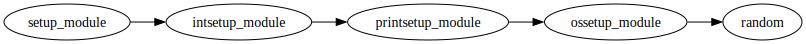

In [1]:
from tec.dependencies import dependency_graph_for

import sklearn

dependency_graph_for(sklearn)

{'_encoding': 'utf-8',
 'filename': 'Digraph.gv',
 'name': None,
 'comment': None,
 'graph_attr': {},
 'node_attr': {},
 'edge_attr': {},
 'body': ['rankdir=LR',
  'setup_module -> random',
  'setup_module -> os',
  'setup_module -> print',
  'setup_module -> int',
  ''],
 'strict': False}

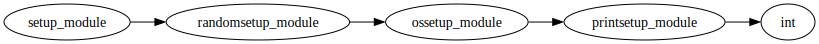

In [20]:
from graphviz import Digraph

Digraph(body=[
  'rankdir="LR"',
  'setup_module -> random',
  'setup_module -> os',
  'setup_module -> print',
  'setup_module -> int'])